In [1]:
print("OSMN")

OSMN


d:\Semester-6\ANN\ImageMatchingDataset\tfenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Semester-6\ANN\ImageMatchingDataset\tfenv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fil

Found 1945 files belonging to 13 classes.
Found 73 files belonging to 2 classes.
Epoch 1/20
122/122 [==============================] - 137s 828ms/step - loss: 1.0163 - val_loss: 1.3104 - lr: 1.0000e-04
Epoch 2/20
122/122 [==============================] - 103s 604ms/step - loss: 0.9589 - val_loss: 1.2054 - lr: 1.0000e-04
Epoch 3/20
122/122 [==============================] - 103s 602ms/step - loss: 0.8692 - val_loss: 1.2215 - lr: 1.0000e-04
Epoch 4/20
122/122 [==============================] - 103s 604ms/step - loss: 0.7237 - val_loss: 1.2727 - lr: 1.0000e-04
Epoch 5/20
122/122 [==============================] - 103s 605ms/step - loss: 0.6361 - val_loss: 1.3034 - lr: 1.0000e-04
Epoch 6/20
122/122 [==============================] - 103s 601ms/step - loss: 0.5547 - val_loss: 1.2701 - lr: 5.0000e-05
Epoch 7/20
3/3 [==============================] - 1s 378ms/step
Validation Accuracy: 0.3014


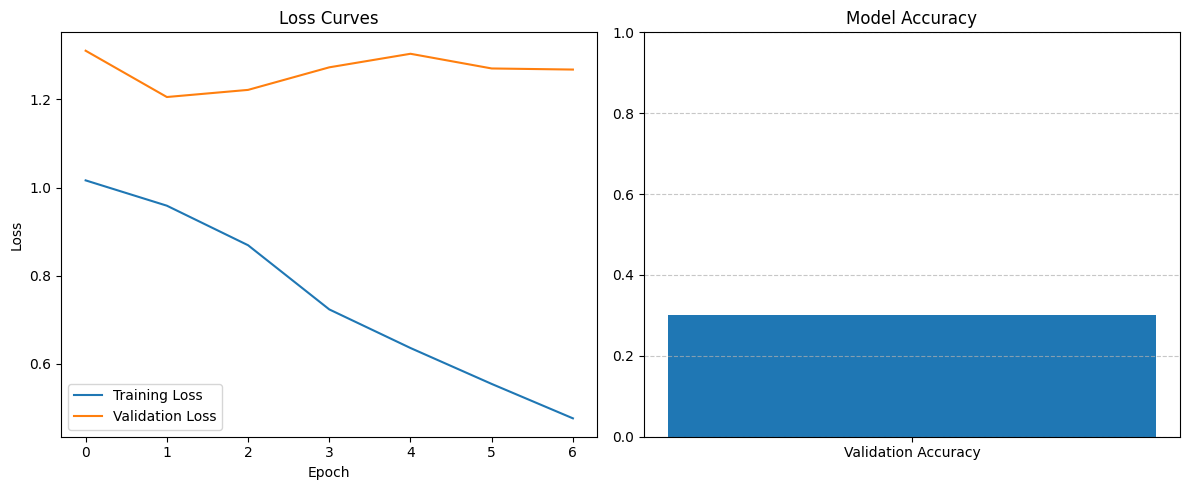

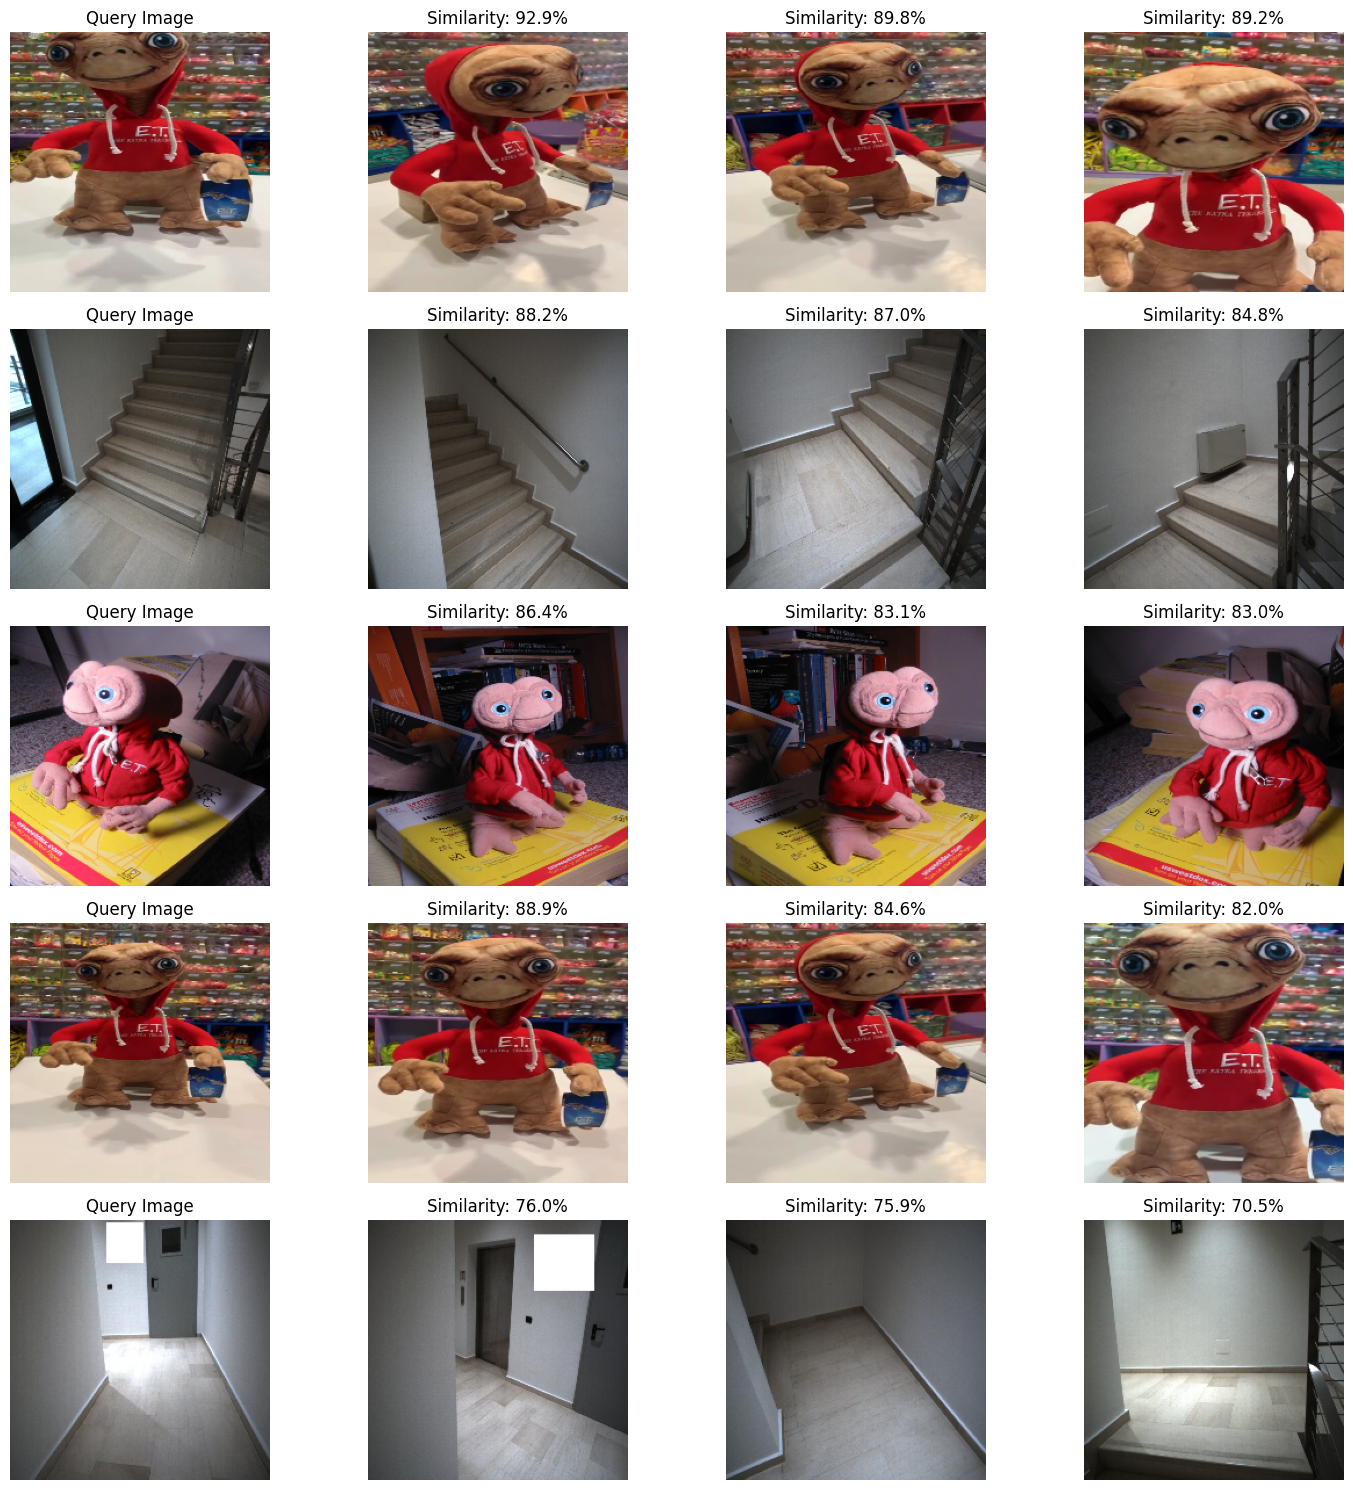

INFO:tensorflow:Assets written to: image_similarity_model\assets


INFO:tensorflow:Assets written to: image_similarity_model\assets


Model saved successfully!


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import show, utils

# Set random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20

# Define data augmentation parameters - reduced intensity for better generalization
DATA_AUG_PARAMS = {
    'BRIGHTNESS': 0.3,
    'HUE': 0.3,
    'CONTRAST_MIN': 0.7,
    'CONTRAST_MAX': 1.3,
    'SATURATION_MIN': 0.7,
    'SATURATION_MAX': 1.3,
    'ZOOM_FACTOR': 0.3,
    'ROTATION_FACTOR': 0.15
}

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join('train'),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,
    shuffle=True
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join("test"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,
    shuffle=False
)

# Create data augmentation pipeline
def augment_image(image):
    image = tf.image.random_brightness(image, DATA_AUG_PARAMS['BRIGHTNESS'])
    image = tf.image.random_contrast(image, DATA_AUG_PARAMS['CONTRAST_MIN'], DATA_AUG_PARAMS['CONTRAST_MAX'])
    image = tf.image.random_hue(image, DATA_AUG_PARAMS['HUE'])
    image = tf.image.random_saturation(image, DATA_AUG_PARAMS['SATURATION_MIN'], DATA_AUG_PARAMS['SATURATION_MAX'])
    image = tf.image.random_flip_left_right(image)
    
    # Apply random zoom
    random_zoom = tf.keras.layers.RandomZoom(DATA_AUG_PARAMS['ZOOM_FACTOR'])
    image = random_zoom(tf.expand_dims(image, 0))[0]
    
    # Apply random rotation
    random_rotation = tf.keras.layers.RandomRotation(DATA_AUG_PARAMS['ROTATION_FACTOR'])
    image = random_rotation(tf.expand_dims(image, 0))[0]
    
    return image

# Prepare datasets
ds_train = (
    train_dataset
    .map(lambda x, y: (x / 255., y))
    .map(lambda x, y: (augment_image(x), y))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    valid_dataset
    .map(lambda x, y: (x / 255., y))
    .batch(BATCH_SIZE * 2)
    .prefetch(tf.data.AUTOTUNE)
)

# Extract class labels for evaluation
train_images, train_labels = [], []
for images, labels in train_dataset.batch(100):
    train_images.append(images.numpy() / 255.0)
    train_labels.append(labels.numpy())
train_images = np.vstack(train_images)
train_labels = np.concatenate(train_labels)

valid_images, valid_labels = [], []
for images, labels in valid_dataset.batch(100):
    valid_images.append(images.numpy() / 255.0)
    valid_labels.append(labels.numpy())
valid_images = np.vstack(valid_images)
valid_labels = np.concatenate(valid_labels)

# Create updated model with regularization and dropout to prevent overfitting
def create_model():
    # Create the base MobileNetV2 model with pre-trained weights
    base_model = keras.applications.MobileNetV2(
        include_top=False, 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet'
    )
    
    # Fine-tune only the top layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    # Build the model
    model = keras.Sequential([
        base_model,
        keras.layers.Dropout(0.3),  # Add dropout for regularization
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),  # Add another dropout layer
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Lambda(lambda x: keras.backend.l2_normalize(x, axis=-1))
    ])
    
    return model

# Create and compile the model
cnn = create_model()
cnn.compile(
    loss=tfa.losses.TripletSemiHardLoss(),  # Use semi-hard triplet loss for better stability
    optimizer=keras.optimizers.Adam(1e-4)
)

# Define learning rate schedule
def schedule_fn(epoch, lr):
    schedule = {
        0: 1e-4,
        10: 5e-5,
        15: 1e-5
    }
    return schedule.get(epoch, lr)

# Define callbacks
callbacks = [
    keras.callbacks.LearningRateScheduler(schedule_fn),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
history = cnn.fit(
    ds_train,
    validation_data=ds_valid,
    callbacks=callbacks,
    epochs=EPOCHS,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate embeddings
train_embeddings = cnn.predict(train_images)
valid_embeddings = cnn.predict(valid_images)

# Calculate accuracy using KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, train_labels)
valid_pred = knn.predict(valid_embeddings)
accuracy = accuracy_score(valid_labels, valid_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

plt.subplot(1, 2, 2)
plt.bar(['Validation Accuracy'], [accuracy])
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate similarity matrix
d2 = utils.get_squared_distance_matrix(valid_embeddings, diag_value=np.inf)

# Function to calculate similarity percentage
def calculate_similarity_percentage(distance):
    """Convert distance to similarity percentage (inverse relationship)"""
    # Lower distance means higher similarity
    # We'll use an exponential decay function: similarity = e^(-distance)
    similarity = np.exp(-distance)
    return similarity * 100  # Convert to percentage

# Visualize similar images with similarity percentages
def show_similar_images_with_percentages(images, distance_matrix, num_images=5, num_similar=3):
    """Show images with their most similar counterparts and similarity percentages"""
    plt.figure(figsize=(15, num_images * 3))
    
    # Randomly select indices to display
    indices = np.random.choice(len(images), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        # Get the distances to all other images
        distances = distance_matrix[idx]
        
        # Get indices of most similar images (excluding itself)
        similar_indices = np.argsort(distances)[:num_similar+1]
        similar_indices = similar_indices[similar_indices != idx][:num_similar]
        
        # Calculate similarity percentages
        similarities = [calculate_similarity_percentage(distances[j]) for j in similar_indices]
        
        # Display query image
        plt.subplot(num_images, num_similar + 1, i * (num_similar + 1) + 1)
        plt.imshow(images[idx])
        plt.title("Query Image")
        plt.axis('off')
        
        # Display similar images with similarity percentages
        for j, (sim_idx, sim_percent) in enumerate(zip(similar_indices, similarities)):
            plt.subplot(num_images, num_similar + 1, i * (num_similar + 1) + j + 2)
            plt.imshow(images[sim_idx])
            plt.title(f"Similarity: {sim_percent:.1f}%")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display similar images with similarity percentages
show_similar_images_with_percentages(valid_images, d2, num_images=5, num_similar=3)

# Function to predict similarity for new images
def predict_similarity(model, image_path1, image_path2):
    """Calculate similarity percentage between two images"""
    # Load and preprocess images
    img1 = keras.preprocessing.image.load_img(image_path1, target_size=(IMG_SIZE, IMG_SIZE))
    img2 = keras.preprocessing.image.load_img(image_path2, target_size=(IMG_SIZE, IMG_SIZE))
    
    img1 = keras.preprocessing.image.img_to_array(img1) / 255.0
    img2 = keras.preprocessing.image.img_to_array(img2) / 255.0
    
    # Get embeddings
    embedding1 = model.predict(np.expand_dims(img1, axis=0))
    embedding2 = model.predict(np.expand_dims(img2, axis=0))
    
    # Calculate distance
    distance = np.sum((embedding1 - embedding2) ** 2)
    
    # Calculate similarity percentage
    similarity = calculate_similarity_percentage(distance)
    
    return similarity

# Example usage (uncomment and provide paths to test)
# similarity = predict_similarity(cnn, 'path/to/image1.jpg', 'path/to/image2.jpg')
# print(f"Images are {similarity:.2f}% similar")

# Save the model
cnn.save('image_similarity_model')
print("Model saved successfully!")

In [4]:
from tensorflow import keras

# Load your saved model
model = keras.models.load_model('image_similarity_model', compile=False)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 224  # Match what you trained with

def calculate_similarity_percentage(distance, scale=5.0):
    """Convert distance to a percentage similarity score"""
    similarity = np.exp(-distance / scale)
    return round(similarity * 100, 2)

def predict_similarity(model, image_path1, image_path2, threshold=0.7, show_images=True):
    """Predict similarity between two images and optionally display them"""
    # Load and preprocess
    img1 = load_img(image_path1, target_size=(IMG_SIZE, IMG_SIZE))
    img2 = load_img(image_path2, target_size=(IMG_SIZE, IMG_SIZE))
    
    img1_array = img_to_array(img1) / 255.0
    img2_array = img_to_array(img2) / 255.0
    
    # Predict embeddings
    emb1 = model.predict(np.expand_dims(img1_array, axis=0), verbose=0)
    emb2 = model.predict(np.expand_dims(img2_array, axis=0), verbose=0)
    
    # Compute distance
    distance = np.linalg.norm(emb1 - emb2)
    similarity = calculate_similarity_percentage(distance)
    prediction = "Similar" if distance < threshold else "Not Similar"
    
    # Display
    if show_images:
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title("Image 1")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title("Image 2")
        plt.axis('off')
        
        plt.suptitle(f"{prediction} ({distance:.2f} Distance)")
        plt.tight_layout()
        plt.show()
    
    return similarity, prediction, distance


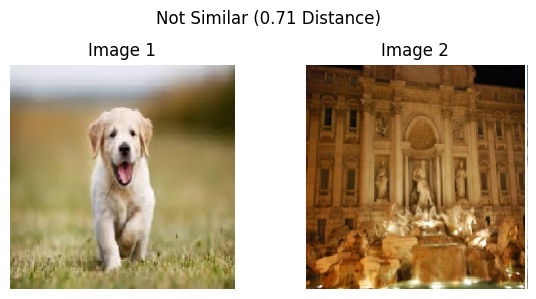

Similarity: 86.68%, Prediction: Not Similar, Distance: 0.7148


In [32]:
similarity, prediction, distance = predict_similarity(
    model,
    'test/d1.jpeg',
    'test/c4.PNG'
)
print(f"Similarity: {similarity}%, Prediction: {prediction}, Distance: {distance:.4f}")


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sift_match_and_show(image_path1, image_path2, num_matches=50):
    """Performs SIFT feature extraction, matches them, and shows the top matches."""

    # Load images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    if image1 is None or image2 is None:
        print("Error: One or both image paths are invalid.")
        return

    # Convert to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Create SIFT detector and extract features
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Draw keypoints
    def show_keypoints(image, keypoints, title):
        img_with_kp = cv2.drawKeypoints(
            image, keypoints, None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        img_with_kp = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 4))
        plt.imshow(img_with_kp)
        plt.title(title)
        plt.axis('off')
        plt.show()

    show_keypoints(image1, keypoints1, "Image 1 Keypoints")
    show_keypoints(image2, keypoints2, "Image 2 Keypoints")

    # Match descriptors using brute force matcher
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw top matches
    matched_img = cv2.drawMatches(
        image1, keypoints1,
        image2, keypoints2,
        matches[:num_matches], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    matched_img = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

    # Show matches
    plt.figure(figsize=(12, 6))
    plt.imshow(matched_img)
    plt.title(f"Top {num_matches} Feature Matches")
    plt.axis('off')
    plt.show()


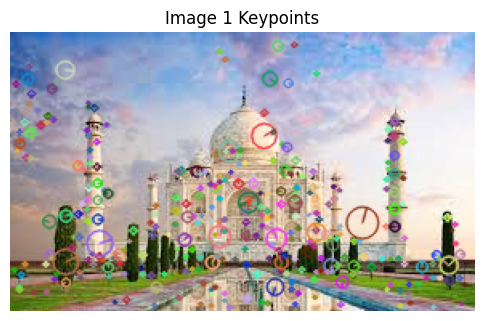

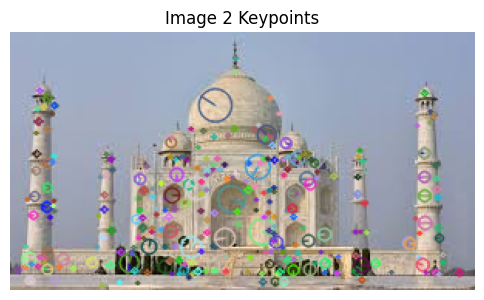

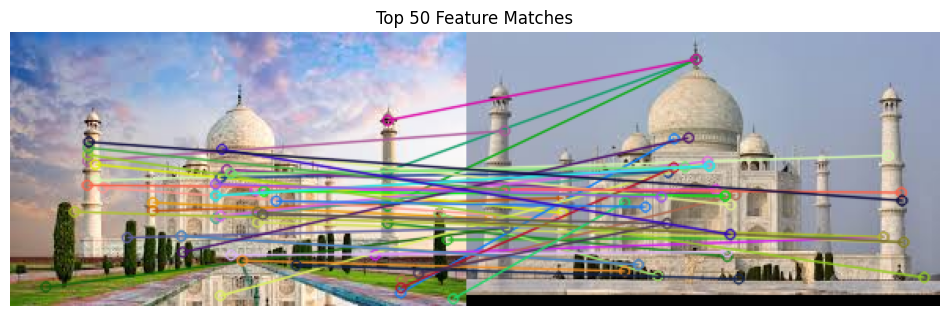

In [38]:
sift_match_and_show('./test/t1.jpeg', './test/t3.jpeg')
